# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
! ls ../eos/Apr12_presel_2017/

DYJetsToLL_M-10to50                     SingleElectron_Run2017E
DYJetsToLL_Pt-100To250                  SingleElectron_Run2017F
DYJetsToLL_Pt-250To400                  SingleMuon_Run2017B
DYJetsToLL_Pt-400To650                  SingleMuon_Run2017C
DYJetsToLL_Pt-50To100                   SingleMuon_Run2017D
DYJetsToLL_Pt-650ToInf                  SingleMuon_Run2017E
GluGluHToTauTau                         SingleMuon_Run2017F
GluGluHToWW_Pt-200ToInf_M-125           TTTo2L2Nu
GluGluZH_HToWW_ZTo2L_M-125              TTToHadronic
HWminusJ_HToWW_M-125                    TTToSemiLeptonic
HWplusJ_HToWW_M-125                     VBFHToWWToLNuQQ_M-125_withDipoleRecoil
HZJ_HToWW_M-125                         WJetsToLNu_HT-100To200
QCD_Pt_1000to1400                       WJetsToLNu_HT-1200To2500
QCD_Pt_1400to1800                       WJetsToLNu_HT-200To400
QCD_Pt_170to300                         WJetsToLNu_HT-2500ToInf
QCD_Pt_1800to2400                       WJetsToLNu_HT-400To600
QCD_Pt_2400to32

In [4]:
presel = {
    "mu": {
#         ### already applied in the latest version of the processor
#         "isolation": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
#         "invert isolation": "( ( (lep_pt < 55) & (lep_isolation>0.15)) |  (lep_pt >= 55) )",

#         "mini-isolation": "( (lep_pt < 55) |  ( (lep_misolation < 0.2) & (lep_pt >= 55) ) )",
#         "invert mini-isolation": "( (lep_pt < 55) |  ( (lep_misolation > 0.2) & (lep_pt >= 55) ) )",

        ### part of the preselection
        "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
        
        ### top region
#         "nbjets": "( (n_bjets_M >= 2) )",
        
        ### wjets control region        
#         "nbjets": "( (n_bjets_M < 1) )",         
    },
    "ele": {
#         ### already applied in the latest version of the processor
#         "isolation": "( ( (lep_pt < 120) & (lep_isolation<0.15)) |  (lep_pt >= 120) )",    
#         "invert isolation": "( ( (lep_pt < 120) & (lep_isolation>0.15)) |  (lep_pt >= 120) )",

        ### part of the preselection
        "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
        
        ### top control region
#         "nbjets": "( (n_bjets_M >= 2) )",
        
        ### wjets control region        
#         "nbjets": "( (n_bjets_M < 1) )",        
    }    
}

weights = {
    "ele": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_electron": 1,
        "weight_pileup": 1,
        "weight_reco_electron": 1,
        "weight_trigger_electron": 1,
        "weight_vjets_nominal": 1,
    },
    "mu": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_muon": 1,
        "weight_isolation_muon": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_vjets_nominal": 1   ,
    },       
}

In [5]:
years = ["2017"] #, "2016", "2016APV", "2018"]
channels = ["mu", "ele"]

samples_dir = f"../eos/Apr12_presel_"

samples = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data"
]

In [6]:
from make_hists import make_events_dict
events_dict = make_events_dict(years, channels, samples_dir, samples, presel, weights, "all", add_inclusive_score=True,
                                  apply_tagger=0.99,
#                                   apply_inverse_tagger=0.99,
                                 )

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Applying preselection.
applying lep_fj_dr selection on 37101 events
---> Done with preselection.
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will apply tagger cut of score>0.99
Will fill the WJetsLNu dataframe with the remaining 13 events
tot event weight 20.55962389652516 

Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> Applying preselection.
applying lep_fj_dr selection on 107935 events
---> Done with preselection.
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying we

---> Applying preselection.
applying lep_fj_dr selection on 4 events
---> Done with preselection.
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will apply tagger cut of score>0.99
Will fill the WZQQ dataframe with the remaining 0 events
tot event weight 0.0 

Finding ST_tW_antitop_5f_inclusiveDecays samples and should combine them under SingleTop
---> Applying preselection.
applying lep_fj_dr selection on 25809 events
---> Done with preselection.
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon

---> Applying preselection.
applying lep_fj_dr selection on 725533 events
---> Done with preselection.
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will apply tagger cut of score>0.99
Will fill the TTbar dataframe with the remaining 1960 events
tot event weight 57.942634906437775 

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Applying preselection.
applying lep_fj_dr selection on 302 events
---> Done with preselection.
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight

---> Applying preselection.
applying lep_fj_dr selection on 290953 events
---> Done with preselection.
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will apply tagger cut of score>0.99
Will fill the WJetsLNu dataframe with the remaining 8564 events
tot event weight 997.1681249509279 

Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
---> Applying preselection.
applying lep_fj_dr selection on 1005 events
---> Done with preselection.
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger

---> Applying preselection.
applying lep_fj_dr selection on 317669 events
---> Done with preselection.
Will apply tagger cut of score>0.99
Will fill the Data dataframe with the remaining 2055 events
tot event weight 2055.0 

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Applying preselection.
applying lep_fj_dr selection on 33749 events
---> Done with preselection.
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will apply tagger cut of score>0.99
Will fill the WJetsLNu dataframe with the remaining 10 events
tot event weight 14.879711978755724 

Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> Applying preselection.
applying lep_fj_dr selection on 

---> Applying preselection.
applying lep_fj_dr selection on 29122 events
---> Done with preselection.
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will apply tagger cut of score>0.99
Will fill the SingleTop dataframe with the remaining 155 events
tot event weight 32.73920021468061 

Finding ZJetsToQQ_HT-200to400 samples and should combine them under WZQQ
---> Applying preselection.
applying lep_fj_dr selection on 33 events
---> Done with preselection.
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applyin

Will apply tagger cut of score>0.99
Will fill the TTbar dataframe with the remaining 2027 events
tot event weight 56.34995903470817 

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Applying preselection.
applying lep_fj_dr selection on 1069 events
---> Done with preselection.
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will apply tagger cut of score>0.99
Will fill the QCD dataframe with the remaining 8 events
tot event weight 0.0005263852113510726 

Finding DYJetsToLL_Pt-650ToInf samples and should combine them under DYJets
---> Applying preselection.
applying lep_fj_dr selection on 192289 events
---> Done with preselection.
---> Accumulating event weights.
Applying weig

Will fill the WJetsLNu dataframe with the remaining 787 events
tot event weight 0.8539520710287334 

Finding ttHToNonbb_M125 samples and should combine them under ttH
---> Applying preselection.
applying lep_fj_dr selection on 20082 events
---> Done with preselection.
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will apply tagger cut of score>0.99
Will fill the ttH dataframe with the remaining 1281 events
tot event weight 4.146348107779454 

Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
---> Applying preselection.
applying lep_fj_dr selection on 2278 events
---> Done with preselection.
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_ge

In [7]:
events_dict.keys()

dict_keys(['2017'])

In [8]:
events_dict["2017"].keys()

dict_keys(['mu', 'ele'])

In [9]:
events_dict["2017"]["mu"].keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Data', 'Diboson', 'ttH'])

# Plot histograms

## 1d-hists

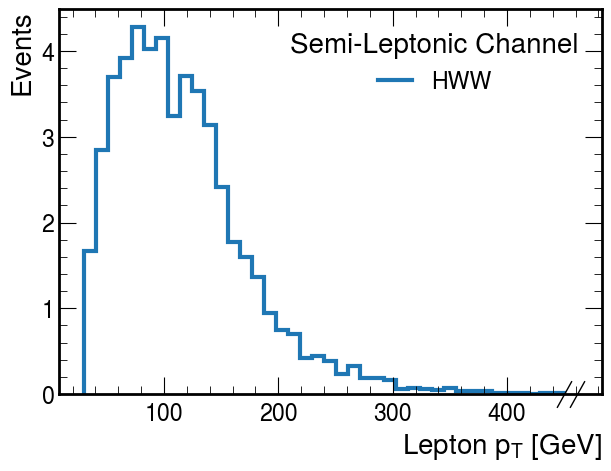

In [10]:
plt.rcParams.update({"font.size": 20})

sample = "HWW"

# make histogram
h = hist2.Hist(
    hist2.axis.Regular(40, 30, 450, name="var", label=r"Lepton $p_T$ [GeV]", overflow=True),
)    

for year in years:
    for ch in channels:

        df = events_dict[year][ch][sample]

        h.fill(
            var=df["lep_pt"],
            weight=df["event_weight"]
        )

# plot histogram
fig, ax = plt.subplots(figsize=(7, 5))

hep.histplot(
    h,
    ax=ax,
    label=sample,
    linewidth=3,
#     density=True
)

ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

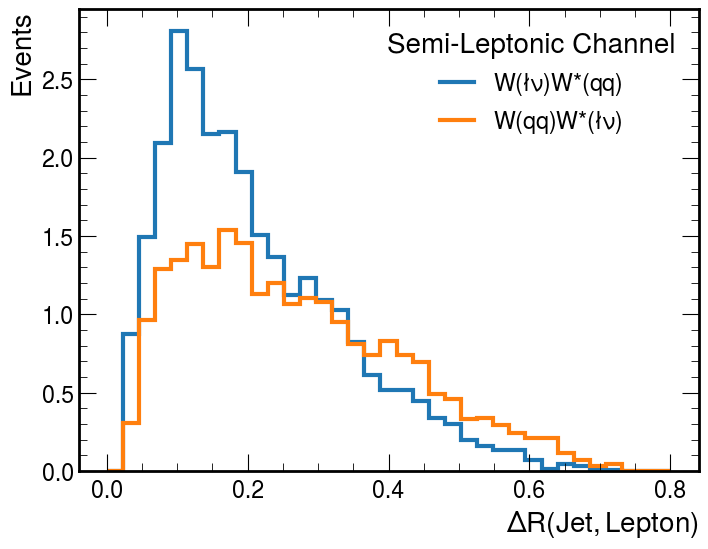

In [11]:
# make histogram
h = hist2.Hist(
    hist2.axis.Regular(35, 0.0, 0.8, name="var", label=r"$\Delta R(Jet, Lepton)$", overflow=True),
    hist2.axis.Boolean(name="from_W")        
)

for year in years:
    for ch in channels:
        
        h.fill(
            var=events_dict[year][ch]["HWW"]["lep_fj_dr"],
            from_W=events_dict[year][ch]["HWW"]["fj_H_VV_isVlepton"]==True,
            weight=events_dict[year][ch]["HWW"]["event_weight"]
        )

# plot histogram
fig, ax = plt.subplots(figsize=(8, 6))

hep.histplot(
    h[{"from_W": 1}],
    ax=ax,
    label=r"W($\l\nu$)W*(qq)",
    linewidth=3,
#     density=True
)
hep.histplot(
    h[{"from_W": 0}],
    ax=ax,
    label=r"W(qq)W*($\l\nu$)",
    linewidth=3,
#     density=True    
)
     
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");

# Stacked hists

In [12]:
vars_to_plot = [
#     "fj_minus_lep_m",
#     "fj_pt",
    "lep_pt",
#     "fj_msoftdrop",
#     "fj_bjets_ophem",
#     "fj_bjets",
#     "lep_fj_dr",
#     "lep_met_mt",
#     "ht",
#     "met_fj_dphi",
#     "deta",
#     "met",
#     "mjj",
#     "fj_pt_over_lep_pt",
#     "rec_higgs_m",
#     "rec_higgs_pt",
#     "rec_higgs_pt_over_lep_pt",    
#     "golden_var",
#     "rec_dphi_WW",
#     "fj_ParT_mass",
#     "fj_ParticleNet_mass"
#     "nj",
#     "inclusive_score"
]

samples_to_plot = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data",
]

In [13]:
channels = ["ele", "mu"]

# fill histograms
hists = {}
for var in vars_to_plot:
            
    hists[var] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.axis_dict[var],
#         hist2.axis.Regular(25, 0.0, 2.5, name="var", label=r"$\Delta R(Jet, Lepton)$", overflow=True)
    )
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
                df = events_dict[year][ch][sample]

    #             df = df[df["fj_pt"]>650]
    #             df = df[df["fj_pt"]<650]            

    #             # tagger cut
    #             df = df[df["inclusive_score"] > 0.99]

    #             df = df[df["fj_minus_lep_m"]>70]
    #             df = df[df["lep_fj_dr"]>0.5]

                # lep and jet overlap cut
    #             df = df[df["fj_pt"]/df["lep_pt"]>1.6]            
    #             df = df[df["lep_fj_dr"]>0.01]

    #             # WJetsLNu control region
    #             df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<2]

    #             # TTbar control region
    #             df = df[df["n_bjets_M"]<2]

    #             df = df[df["met"]<100]

                if var=="golden_var":
                    hists[var].fill(
                        samples=sample,
                        var=df["rec_W_lnu_pt"]/df["rec_W_qq_pt"],
                        weight=df["event_weight"]
                    )                 
                elif var == "fj_pt_over_lep_pt":
                    hists[var].fill(
                        samples=sample,
                        var=df["fj_pt"]/df["lep_pt"],
                        weight=df["event_weight"]
                    )
                elif var=="rec_higgs_pt_over_lep_pt":
                    hists[var].fill(
                        samples=sample,
                        var=df["rec_higgs_pt"]/df["lep_pt"],
                        weight=df["event_weight"]
                    )                
                elif var=="rec_dphi_WW":
                    hists[var].fill(
                        samples=sample,
                        var=np.abs(df["rec_dphi_WW"]),
                        weight=df["event_weight"]
                    )     
                elif var=="fj_msoftdrop+met":
                    hists[var].fill(
                        samples=sample,
                        var=df["fj_msoftdrop"]+df["met"],
                        weight=df["event_weight"]
                    )   
                elif var=="fj_ParT_mass-met":
                    hists[var].fill(
                        samples=sample,
                        var=df["fj_ParT_mass"]-df["met"],
                        weight=df["event_weight"]
                    )  
                elif var=="met_fj_dphi":
                    hists[var].fill(
                        samples=sample,
                        var=np.abs(df["met_fj_dphi"]),
                        weight=df["event_weight"]
                    )                  
                else:
                    hists[var].fill(
                        samples=sample,
                        var=df[var],
                        weight=df["event_weight"]
                    )

Will plot lep_pt histogram


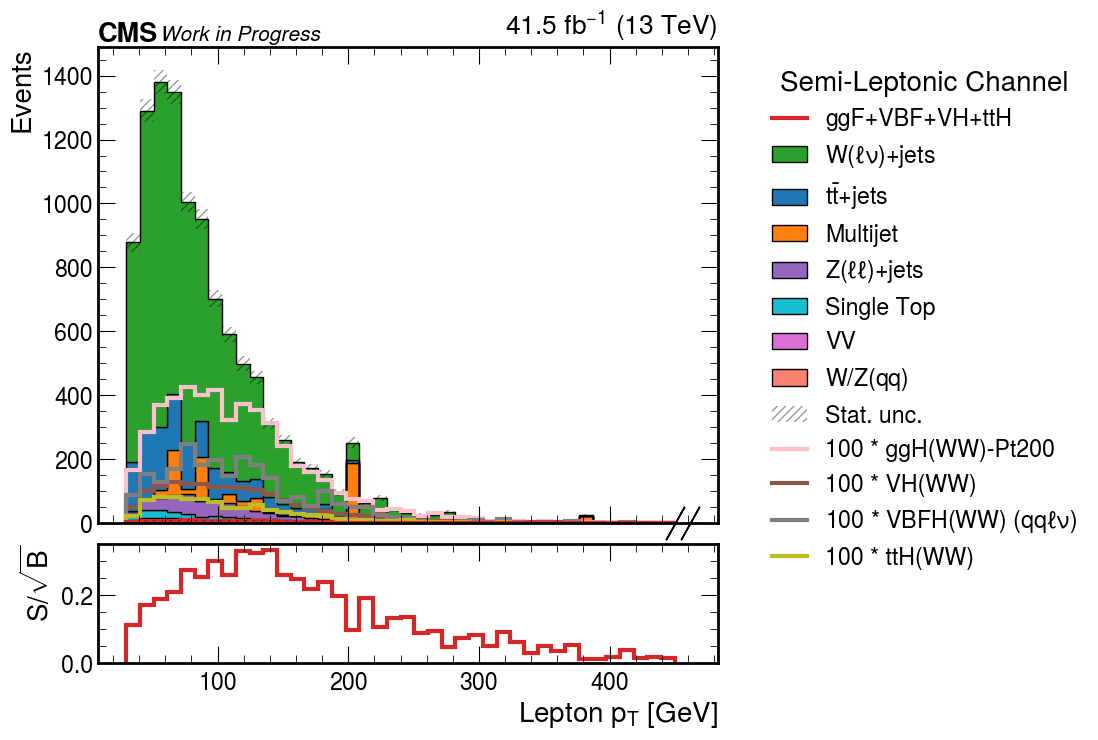

In [14]:
plt.rcParams.update({"font.size": 20})
from utils import plot_hists
plot_hists(years, channels, hists, vars_to_plot,             
            add_data=False,
            logy=False,
            add_soverb=True,
            only_sig=False,
            mult=100,
            outpath="/Users/fmokhtar/Desktop/farakiko/")

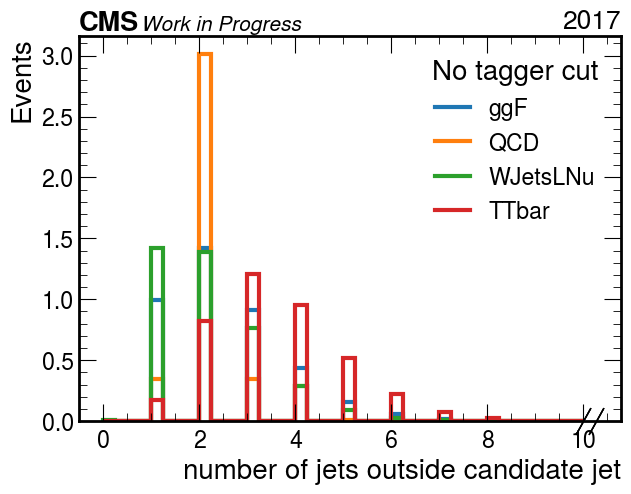

In [20]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
     "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

var = "nj"
# var = "met_fj_dphi"
# var = "lep_met_mt"
# var = "mjj"


h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    utils.axis_dict[var],
)  
    
fig, ax = plt.subplots(figsize=(7, 5))

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            df = events_dict[year][ch][sample]

            # tagger cut
    #         df = df[df["inclusive_score"]>0.9]

    #         df = df[df["lep_fj_dr"]>0.03]        
            df = df[df["n_bjets_M"]<2]
    #         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]

            h.fill(
                samples=sample,
                var=df[var],
                weight=df["event_weight"]
            )

for sample in samples_to_plot:
    if sample in utils.sig_labels:
        lab = utils.sig_labels[sample]
    else:
        lab = sample
        
    hep.histplot(
        h[{"samples":sample}],
        ax=ax,
        label=lab,
        linewidth=3,
        density=True
    )

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"No tagger cut")
ax.set_ylabel("Events");  
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

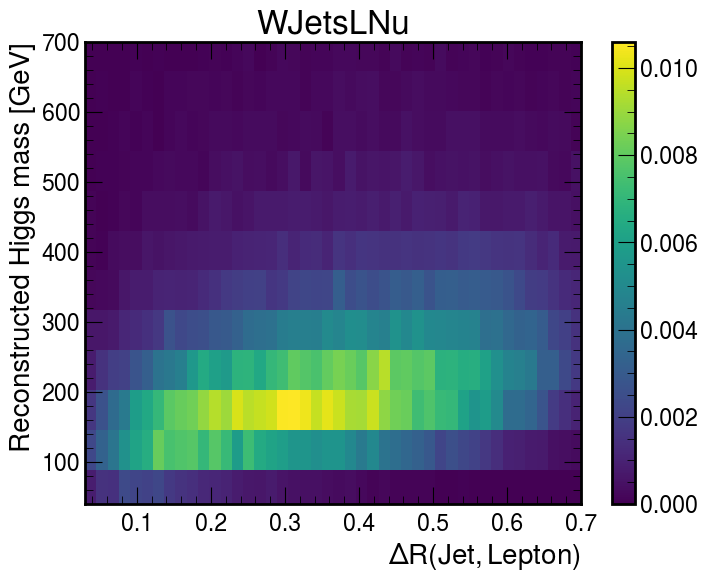

In [16]:
samples_to_plot = [
#     "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
    "WJetsLNu",
#     "TTbar",
]

var1 = "lep_fj_dr"
var2 = "rec_higgs_m"

from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(8, 6))

for sample in samples_to_plot:
    for year in years:
        for i, ch in enumerate(channels):
            df = events_dict[year][ch][sample]

            df = df[df["inclusive_score"]>0.99]
            df = df[df["fj_pt"]>220]

            if i==0:
                dff = df
            else:
                dff = pd.concat([dff, df])


    x = dff[var1].dropna()
    y = dff[var2].dropna()

    plt.hist2d(
        x,
        y,
        density=True,
#         norm=LogNorm(),
        bins=[50,50]
          )

ax.set_xlim(0.03,0.7)
ax.set_ylim(40, 700)
ax.set_xlabel(r"$\Delta R(Jet,Lepton)}$");
ax.set_ylabel(r"Reconstructed Higgs mass [GeV]");
ax.set_title(sample)
plt.colorbar()

### save plot
save_as = f"/Users/fmokhtar/Desktop/hww/{samples_dir[3:]}/"
plt.savefig(f"{save_as}/2d-{var1}-{var2}-{sample}.pdf", bbox_inches='tight')